In [1]:
# Extra Setup for Colaboratory Environment

#!pip install cmake
#!pip install dlib

#from google.colab import files
#uploaded = files.upload() 

#!7za e colaboratory_dependencies.7z
#!7za x frontalization_models.7z
#!7za x dlib_models.7z

In [2]:
'''
Libraries, etc.
'''
import os
import sys
import cv2
import numpy as np 
import scipy as sp
import pandas as pd 
import seaborn as sns
from math import sqrt
import scipy.io as io
import tensorflow as tf 
from pathlib import Path
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix

from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.utils import np_utils as npu
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Convolution2D, Activation, BatchNormalization, GaussianNoise, MaxPooling2D, Dropout, Dense, Flatten

import frontalize
import check_resources as check
import camera_calibration as calib
import facial_feature_detector as feature_detection

from models import get_model1, get_model2, get_model3

#this_path = os.path.dirname(os.path.abspath(__file__)) 
this_path = str(Path().resolve()) # for Colaboratory

Using TensorFlow backend.


In [3]:
'''
Constants, Hyperparameters, etc.
'''
BATCH_SIZE = 128
NUM_EPOCHS = 85
input_file = 'fer2013.csv'
filepath = 'Model.{epoch:02d}-{val_acc:.4f}.hdf5'

model1_acc_file = "acc_model1_t2.png"
model2_acc_file = "acc_model2_t2.png"
model3_acc_file = "acc_model3_t2.png"
model4_acc_file = "acc_model4_t2.png"
acc_file = model1_acc_file

model1_loss_file = "loss_model1_t2.png"
model2_loss_file = "loss_model2_t2.png"
model3_loss_file = "loss_model3_t2.png"
model4_loss_file = "loss_model4_t2.png"
loss_file = model1_loss_file

model1_cm_file = "cm_model1_t2.png"
model2_cm_file = "cm_model2_t2.png"
model3_cm_file = "cm_model3_t2.png"
model4_cm_file = "cm_model4_t2.png"
cm_file = model1_cm_file

emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
num_classes = len(emotion_labels)

In [4]:
'''
Load & Parse Data into Training/Test Labels & Images
'''
data = pd.read_csv(input_file)
data.head()

# get data and labels
train_set = data[(data.Usage == 'Training')]
validation_set = data[(data.Usage == 'PublicTest')]
test_set = data[(data.Usage == 'PrivateTest')]

# greyscale so depth 1
depth = 1
height = int(sqrt(len(data.pixels[0].split())))
width = height

# from pandas to np array
X_train = np.array(list(map(str.split, train_set.pixels)), np.uint8)
X_validation = np.array(list(map(str.split, validation_set.pixels)), np.uint8)
X_test = np.array(list(map(str.split, test_set.pixels)), np.uint8)

# reshape data
num_train = X_train.shape[0]
num_validation = X_validation.shape[0]
num_test = X_test.shape[0]

X_train = X_train.reshape(num_train, width, height, depth)
X_validation = X_validation.reshape(num_validation, width, height, depth)
X_test = X_test.reshape(num_test, width, height, depth)

y_train = train_set.emotion
y_validation = validation_set.emotion
y_test = test_set.emotion

y_train = np_utils.to_categorical(y_train, num_classes)
y_validation = np_utils.to_categorical(y_validation, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

# print shapes
print('X_training: ', X_train.shape)
print('X_validation: ', X_validation.shape)
print('X_test: ', X_test.shape)
print( )
print('y_training: ', y_train.shape)
print('y_validation: ', y_validation.shape)
print('y_test: ', y_test.shape)

X_training:  (28709, 48, 48, 1)
X_validation:  (3589, 48, 48, 1)
X_test:  (3589, 48, 48, 1)

y_training:  (28709, 7)
y_validation:  (3589, 7)
y_test:  (3589, 7)


In [5]:
'''
Frontalization Function
'''
def myfrontalize(X, limit=0):
  count = 0

  if (limit == 0):
    limit = X.shape[0]
    
  print("Total Images: ", limit)
    
  # check for dlib saved weights for face landmark detection
  # if it fails, dowload and extract it manually from
  # http://sourceforge.net/projects/dclib/files/dlib/v18.10/shape_predictor_68_face_landmarks.dat.bz2
  check.check_dlib_landmark_weights()
    
  # load detections performed by dlib library on 3D model and Reference Image
  model3D = frontalize.ThreeD_Model(this_path + "/frontalization_models/model3Ddlib.mat", 'model_dlib')
  
  # load mask to exclude eyes from symmetry
  eyemask = np.asarray(io.loadmat('frontalization_models/eyemask.mat')['eyemask'])
        
  for i in range(0, limit):
    print("\r", end='')
    print("Images Completed: {0}".format(i), end='', flush=True)

    # cast img to type int for cv2
    img = X[i, :, :, 0].astype(np.uint8)
    
    # create a color version for frontalizer stuffs
    c_img = np.copy(img)
    c_img = cv2.cvtColor(c_img, cv2.COLOR_GRAY2BGR)    
    
    # extract landmarks from the query image
    # list containing a 2D array with points (x, y) for each face detected in the query image
    lmarks = feature_detection.get_landmarks(c_img)
    if type(lmarks) is np.ndarray:
      
      # perform camera calibration according to the first face detected
      proj_matrix, camera_matrix, rmat, tvec = calib.estimate_camera(model3D, lmarks[0])
      
      # perform frontalization and convert result to grayscale
      frontal_raw, frontal_sym = frontalize.frontalize(c_img, proj_matrix, model3D.ref_U, eyemask)
      temp = cv2.cvtColor(frontal_raw, cv2.COLOR_BGR2GRAY)
    
      # find nonzero bbox and crop image to remove uncessesary black space from edges           
      temp_mask = cv2.findNonZero(temp)     
      t_x, t_y, t_w, t_h = cv2.boundingRect(temp_mask)
      t_bbox = temp[t_y:t_y+t_h, t_x:t_x+t_w]

      # resize the cropped image to the appropriate dimensions for network
      t_bbox = cv2.resize(t_bbox, dsize=(48, 48))  
      t_bbox = np.resize(t_bbox, (48, 48, 1))   
      X[i] = t_bbox.astype(np.float32)
    
      plt.show()
      count += 1
      
  print( )
  print('{} images out of {} were frontalized.'.format(count, limit))

Original Images


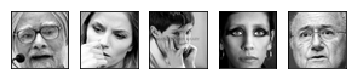

Original w/ Linear Transform to normalize pixel values


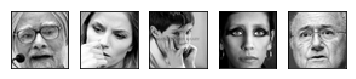

Normalized w/ Contrast Limited Adaptive Histogram Equalization


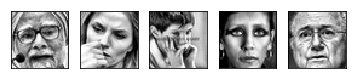

Frontalized, Cropped, and Resized


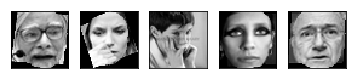

In [6]:
'''
Histogram Equalization - Not defined as method, because 
train has a special case to catch and delete harmful inputs
'''
clahe = cv2.createCLAHE(clipLimit=3.235, tileGridSize=(5,5))

# original image set
X_train1 = X_train.copy().astype(np.uint8)
X_val1 = X_validation.copy().astype(np.uint8)
X_test1 = X_test.copy().astype(np.uint8)

# linear histogram equalization set
X_train2 = X_train1.copy() 
X_val2 = X_val1.copy()
X_test2 = X_test1.copy()

# clahe set
X_train3 = X_train1.copy()
X_val3 = X_val1.copy()
X_test3 = X_test1.copy()

# frontalized set
X_train4 = X_train1.copy()
X_val4 = X_val1.copy()
X_test4 = X_test1.copy()

# histogram equalization
i = 0
while (i < num_train):
  tMax = X_train1[i].max()
  tMin = X_train1[i].min()  

  if (tMax > tMin):
    tRatio = 255 / (tMax - tMin)
    X_train2[i] = np.multiply((X_train1[i] - tMin), tRatio)
    X_train3[i] = clahe.apply(X_train2[i])[:,:,np.newaxis]
    i += 1
    
  # Delete harmful training examples from X_train
  else:
    X_train1 = np.delete(X_train1, (i), axis=0)
    X_train2 = np.delete(X_train2, (i), axis=0)
    X_train3 = np.delete(X_train3, (i), axis=0)
    X_train4 = np.delete(X_train4, (i), axis=0)
    y_train = np.delete(y_train, (i), axis=0)
    num_train -= 1
  
i = 0
while (i < num_validation):
  tMax = X_val1[i].max()
  tMin = X_val1[i].min()

  if (tMax > tMin):
    tRatio = 255 / (tMax - tMin)
    X_val2[i] = np.multiply((X_val1[i] - tMin), tRatio).round()
    
  # Shouldn't delete validation data... skip so we don't divide by 0
  else:
    X_val2[i] = X_val1[i]

  X_val3[i] = clahe.apply(X_val2[i])[:,:,np.newaxis]
  i += 1

i = 0
while (i < num_test):
  tMax = X_test1[i].max()
  tMin = X_test1[i].min()

  if (tMax > tMin):
    tRatio = 255 / (tMax - tMin)
    X_test2[i] = np.multiply((X_test1[i] - tMin), tRatio).round()
    
  # Shouldn't delete test data... skip so we don't divide by 0
  else:
    X_test2[i] = X_test1[i]
    
  X_test3[i] = clahe.apply(X_test2[i])[:,:,np.newaxis]
  i += 1
  
# apply frontalization
#print("Attempting to frontalize image data...")
#myfrontalize(X_train4, num_train)
#np.save('X_train_frontalized', X_train4)

#myfrontalize(X_val4, num_validation)
#np.save('X_val_frontalized', X_val4)

#myfrontalize(X_test4, num_test)
#np.save('X_test_frontalized', X_test4)

X_train4 = np.load('X_train_frontalized.npy')
X_val4 = np.load('X_val_frontalized.npy')
X_test4 = np.load('X_test_frontalized.npy')


# print examples from each set
print('Original Images')
for x in range(1,6):
    plt.subplot(1, 5, x)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train1[x,:,:,0], cmap='gray') 
plt.show()

print('Original w/ Linear Transform to normalize pixel values')
for x in range(1,6):
    plt.subplot(1, 5, x)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train2[x,:,:,0], cmap='gray')   
plt.show()

print('Normalized w/ Contrast Limited Adaptive Histogram Equalization')
for x in range(1,6):
    plt.subplot(1, 5, x)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train3[x,:,:,0], cmap='gray')    
plt.show() 

print('Frontalized, Cropped, and Resized')
for x in range(1,6):
  plt.subplot(1, 5, x)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(X_train4[x, :, :, 0], cmap='gray') 
    
plt.show()

In [7]:
'''
TensorFlow Model(s)
'''

# shallow model
def get_model1():
  model = Sequential()

  model.add(Convolution2D(64, (3, 3), padding='same', input_shape=(48,48,1)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(128, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(256, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(512, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Flatten())

  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Dense(7))
  model.add(Activation('softmax'))

  return model

# actual model
def get_model2():
  model = Sequential()

  model.add(Convolution2D(64, (3, 3), padding='same', input_shape=(48,48,1)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(128, (5, 5), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(512, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(512, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Flatten())

  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Dense(7))
  model.add(Activation('softmax'))

  return model

# deeper model
def get_model3():
  model = Sequential()

  model.add(Convolution2D(64, (3, 3), padding='same', input_shape=(48,48,1)))
  model.add(Convolution2D(64, (3, 3), padding='same')) 
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.4))

  model.add(Convolution2D(128, (3, 3), padding='same'))
  model.add(Convolution2D(128, (3, 3), padding='same')) 
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.4))

  model.add(Convolution2D(256, (3, 3), padding='same'))
  model.add(Convolution2D(265, (3, 3), padding='same')) 
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.4))

  model.add(Convolution2D(512, (3, 3), padding='same'))
  model.add(Convolution2D(512, (3, 3), padding='same')) 
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.4))

  model.add(Flatten())

  model.add(Dense(2048))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.4))

  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.4))

  model.add(Dense(7))
  model.add(Activation('softmax'))

  return model

# shallow model
def get_model4():
  model = Sequential()

  model.add(Convolution2D(64, (3, 3), padding='same', input_shape=(48,48,1)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(128, (5, 5), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Flatten())

  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Dense(7))
  model.add(Activation('softmax'))

  return model

In [8]:
'''
Metric(s)
'''

# metric to balance precision and recall
def fbeta(y_true, y_pred, threshold_shift=0):
  beta = 1

  # just in case of hipster activation at the final layer
  y_pred = K.clip(y_pred, 0, 1)

  # shifting the prediction threshold from .5 if needed
  y_pred_bin = K.round(y_pred + threshold_shift)

  tp = K.sum(K.round(y_true * y_pred_bin), axis=1) + K.epsilon()
  fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)), axis=1)
  fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

  precision = tp / (tp + fp)
  recall = tp / (tp + fn)

  beta_squared = beta ** 2
  return K.mean((beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon()))


In [15]:
'''
Prepare Model for Training
'''
# assign the desired model from above
model1 = get_model1()
model2 = get_model2()
model3 = get_model3()
model4 = get_model4()

#model.summary()

num_train = len(X_train)

# assign X to the desired image set(s) from above
X_train = X_train1.copy()
X_validation = X_val1.copy()
X_test = X_test1.copy()

# reshape X to expected shape and cast it back to type float32
X_train = X_train.reshape(num_train,width,height,1).astype(np.float32)
X_validation = X_validation.reshape(num_validation,width,height,1).astype(np.float32)
X_test = X_test.reshape(num_test,width,height,1).astype(np.float32)

# augment and fit data
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0,
    zoom_range=0.0,
    horizontal_flip=True,
    vertical_flip=False)
datagen.fit(X_train)
datagen.fit(X_validation)

# to be applied during training
checkpointer = ModelCheckpoint(
    filepath, monitor='val_loss', verbose=1, 
    save_best_only=False, mode='auto')
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, 
    patience=10, verbose=0, mode='auto', 
    min_delta=0.0001, cooldown=0, min_lr=0)
early_stop = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=0, 
    verbose=0, mode='auto')

# prepare model to train
model1.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=[fbeta, 'accuracy'])

model2.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=[fbeta, 'accuracy'])

model3.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=[fbeta, 'accuracy'])

model4.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=[fbeta, 'accuracy'])

In [16]:
'''
Training
'''
train_flow = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_flow = datagen.flow(X_validation, y_validation)

history1 = model1.fit_generator(
    train_flow,
    steps_per_epoch= num_train / BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    validation_data=validation_flow,
    validation_steps=num_validation / BATCH_SIZE,
    callbacks=[checkpointer, reduce_lr, checkpointer]
)

history2 = model2.fit_generator(
    train_flow,
    steps_per_epoch= num_train / BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    validation_data=validation_flow,
    validation_steps=num_validation / BATCH_SIZE,
    callbacks=[checkpointer, reduce_lr, checkpointer]
)

history3 = model3.fit_generator(
    train_flow,
    steps_per_epoch= num_train / BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    validation_data=validation_flow,
    validation_steps=num_validation / BATCH_SIZE,
    callbacks=[checkpointer, reduce_lr, checkpointer]
)

history4 = model4.fit_generator(
    train_flow,
    steps_per_epoch= num_train / BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    validation_data=validation_flow,
    validation_steps=num_validation / BATCH_SIZE,
    callbacks=[checkpointer, reduce_lr, checkpointer]
)

Epoch 1/85
225/224 [==============================] - 11s 47ms/step - loss: 1.7710 - fbeta: 0.1166 - acc: 0.3203 - val_loss: 1.9604 - val_fbeta: 0.2209 - val_acc: 0.3093

Epoch 00001: saving model to Model.01-0.3093.hdf5

Epoch 00001: saving model to Model.01-0.3093.hdf5
Epoch 2/85
225/224 [==============================] - 7s 33ms/step - loss: 1.4331 - fbeta: 0.2401 - acc: 0.4492 - val_loss: 1.3448 - val_fbeta: 0.2446 - val_acc: 0.5043

Epoch 00002: saving model to Model.02-0.5043.hdf5

Epoch 00002: saving model to Model.02-0.5043.hdf5
Epoch 3/85
225/224 [==============================] - 7s 33ms/step - loss: 1.2932 - fbeta: 0.2977 - acc: 0.5058 - val_loss: 1.4263 - val_fbeta: 0.3276 - val_acc: 0.459199 -  - ETA

Epoch 00003: saving model to Model.03-0.4591.hdf5

Epoch 00003: saving model to Model.03-0.4591.hdf5
Epoch 4/85
225/224 [==============================] - 8s 34ms/step - loss: 1.2216 - fbeta: 0.3347 - acc: 0.5334 - val_loss: 1.1482 - val_fbeta: 0.3774 - val_acc: 0.5738

Epoch

225/224 [==============================] - 8s 33ms/step - loss: 0.5565 - fbeta: 0.7340 - acc: 0.7943 - val_loss: 1.0220 - val_fbeta: 0.5970 - val_acc: 0.6659

Epoch 00031: saving model to Model.31-0.6659.hdf5

Epoch 00031: saving model to Model.31-0.6659.hdf5
Epoch 32/85
225/224 [==============================] - 8s 35ms/step - loss: 0.5436 - fbeta: 0.7433 - acc: 0.7998 - val_loss: 1.0519 - val_fbeta: 0.6115 - val_acc: 0.6615

Epoch 00032: saving model to Model.32-0.6615.hdf5

Epoch 00032: saving model to Model.32-0.6615.hdf5
Epoch 33/85
225/224 [==============================] - 8s 33ms/step - loss: 0.5402 - fbeta: 0.7466 - acc: 0.8011 - val_loss: 0.8876 - val_fbeta: 0.6304 - val_acc: 0.6983

Epoch 00033: saving model to Model.33-0.6983.hdf5

Epoch 00033: saving model to Model.33-0.6983.hdf5
Epoch 34/85
225/224 [==============================] - 8s 33ms/step - loss: 0.5372 - fbeta: 0.7501 - acc: 0.8039 - val_loss: 1.0727 - val_fbeta: 0.6045 - val_acc: 0.6584

Epoch 00034: saving model

225/224 [==============================] - 8s 33ms/step - loss: 0.4594 - fbeta: 0.7911 - acc: 0.8302 - val_loss: 1.1178 - val_fbeta: 0.6142 - val_acc: 0.6487

Epoch 00061: saving model to Model.61-0.6487.hdf5

Epoch 00061: saving model to Model.61-0.6487.hdf5
Epoch 62/85
225/224 [==============================] - 8s 33ms/step - loss: 0.4556 - fbeta: 0.7930 - acc: 0.8313 - val_loss: 1.0932 - val_fbeta: 0.6131 - val_acc: 0.6562

Epoch 00062: saving model to Model.62-0.6562.hdf5

Epoch 00062: saving model to Model.62-0.6562.hdf5
Epoch 63/85
225/224 [==============================] - 8s 34ms/step - loss: 0.4605 - fbeta: 0.7900 - acc: 0.8315 - val_loss: 0.9524 - val_fbeta: 0.6371 - val_acc: 0.6781

Epoch 00063: saving model to Model.63-0.6781.hdf5

Epoch 00063: saving model to Model.63-0.6781.hdf5
Epoch 64/85
225/224 [==============================] - 8s 33ms/step - loss: 0.4635 - fbeta: 0.7888 - acc: 0.8302 - val_loss: 1.0044 - val_fbeta: 0.6228 - val_acc: 0.6670

Epoch 00064: saving model

225/224 [==============================] - 9s 41ms/step - loss: 1.1169 - fbeta: 0.3979 - acc: 0.5748 - val_loss: 1.3429 - val_fbeta: 0.2575 - val_acc: 0.4752

Epoch 00006: saving model to Model.06-0.4752.hdf5

Epoch 00006: saving model to Model.06-0.4752.hdf5
Epoch 7/85
225/224 [==============================] - 9s 41ms/step - loss: 1.0870 - fbeta: 0.4184 - acc: 0.5851 - val_loss: 1.1274 - val_fbeta: 0.3815 - val_acc: 0.5668

Epoch 00007: saving model to Model.07-0.5668.hdf5

Epoch 00007: saving model to Model.07-0.5668.hdf5
Epoch 8/85
225/224 [==============================] - 9s 42ms/step - loss: 1.0496 - fbeta: 0.4439 - acc: 0.6034 - val_loss: 1.2688 - val_fbeta: 0.3885 - val_acc: 0.5261

Epoch 00008: saving model to Model.08-0.5261.hdf5

Epoch 00008: saving model to Model.08-0.5261.hdf5
Epoch 9/85
225/224 [==============================] - 9s 41ms/step - loss: 1.0255 - fbeta: 0.4607 - acc: 0.6148 - val_loss: 1.1909 - val_fbeta: 0.3685 - val_acc: 0.5463

Epoch 00009: saving model to

225/224 [==============================] - 9s 41ms/step - loss: 0.4112 - fbeta: 0.8144 - acc: 0.8493 - val_loss: 1.1507 - val_fbeta: 0.6404 - val_acc: 0.6770

Epoch 00036: saving model to Model.36-0.6770.hdf5

Epoch 00036: saving model to Model.36-0.6770.hdf5
Epoch 37/85
225/224 [==============================] - 9s 41ms/step - loss: 0.4006 - fbeta: 0.8184 - acc: 0.8520 - val_loss: 1.0186 - val_fbeta: 0.6616 - val_acc: 0.6950

Epoch 00037: saving model to Model.37-0.6950.hdf5

Epoch 00037: saving model to Model.37-0.6950.hdf5
Epoch 38/85
225/224 [==============================] - 9s 41ms/step - loss: 0.3904 - fbeta: 0.8283 - acc: 0.8571 - val_loss: 1.1517 - val_fbeta: 0.6131 - val_acc: 0.6498

Epoch 00038: saving model to Model.38-0.6498.hdf5

Epoch 00038: saving model to Model.38-0.6498.hdf5
Epoch 39/85
225/224 [==============================] - 9s 41ms/step - loss: 0.3782 - fbeta: 0.8328 - acc: 0.8600 - val_loss: 1.1018 - val_fbeta: 0.6448 - val_acc: 0.6804

Epoch 00039: saving model

225/224 [==============================] - 9s 41ms/step - loss: 0.3192 - fbeta: 0.8631 - acc: 0.8820 - val_loss: 1.2873 - val_fbeta: 0.6250 - val_acc: 0.6638

Epoch 00066: saving model to Model.66-0.6638.hdf5

Epoch 00066: saving model to Model.66-0.6638.hdf5
Epoch 67/85
225/224 [==============================] - 9s 41ms/step - loss: 0.3108 - fbeta: 0.8676 - acc: 0.8869 - val_loss: 1.2161 - val_fbeta: 0.6570 - val_acc: 0.6792

Epoch 00067: saving model to Model.67-0.6792.hdf5

Epoch 00067: saving model to Model.67-0.6792.hdf5
Epoch 68/85
225/224 [==============================] - 9s 41ms/step - loss: 0.3146 - fbeta: 0.8682 - acc: 0.8872 - val_loss: 1.0592 - val_fbeta: 0.6746 - val_acc: 0.6994

Epoch 00068: saving model to Model.68-0.6994.hdf5

Epoch 00068: saving model to Model.68-0.6994.hdf5
Epoch 69/85
225/224 [==============================] - 9s 41ms/step - loss: 0.3114 - fbeta: 0.8666 - acc: 0.8864 - val_loss: 1.2637 - val_fbeta: 0.6207 - val_acc: 0.6358

Epoch 00069: saving model

225/224 [==============================] - 14s 61ms/step - loss: 1.0750 - fbeta: 0.4283 - acc: 0.5936 - val_loss: 1.1513 - val_fbeta: 0.4677 - val_acc: 0.5830

Epoch 00011: saving model to Model.11-0.5830.hdf5

Epoch 00011: saving model to Model.11-0.5830.hdf5
Epoch 12/85
225/224 [==============================] - 14s 62ms/step - loss: 1.0612 - fbeta: 0.4324 - acc: 0.5959 - val_loss: 1.1462 - val_fbeta: 0.4895 - val_acc: 0.5860

Epoch 00012: saving model to Model.12-0.5860.hdf5

Epoch 00012: saving model to Model.12-0.5860.hdf5
Epoch 13/85
225/224 [==============================] - 14s 62ms/step - loss: 1.0434 - fbeta: 0.4451 - acc: 0.6021 - val_loss: 1.0219 - val_fbeta: 0.4483 - val_acc: 0.6228

Epoch 00013: saving model to Model.13-0.6228.hdf5

Epoch 00013: saving model to Model.13-0.6228.hdf5
Epoch 14/85
225/224 [==============================] - 14s 61ms/step - loss: 1.0334 - fbeta: 0.4544 - acc: 0.6066 - val_loss: 1.2285 - val_fbeta: 0.4073 - val_acc: 0.5485

Epoch 00014: saving m

225/224 [==============================] - 14s 61ms/step - loss: 0.7005 - fbeta: 0.6500 - acc: 0.7358 - val_loss: 0.9084 - val_fbeta: 0.6228 - val_acc: 0.6897

Epoch 00041: saving model to Model.41-0.6897.hdf5

Epoch 00041: saving model to Model.41-0.6897.hdf5
Epoch 42/85
225/224 [==============================] - 14s 61ms/step - loss: 0.7016 - fbeta: 0.6520 - acc: 0.7374 - val_loss: 0.8492 - val_fbeta: 0.6110 - val_acc: 0.6789

Epoch 00042: saving model to Model.42-0.6789.hdf5

Epoch 00042: saving model to Model.42-0.6789.hdf5
Epoch 43/85
225/224 [==============================] - 14s 61ms/step - loss: 0.6885 - fbeta: 0.6586 - acc: 0.7417 - val_loss: 0.9560 - val_fbeta: 0.5960 - val_acc: 0.6593

Epoch 00043: saving model to Model.43-0.6593.hdf5

Epoch 00043: saving model to Model.43-0.6593.hdf5
Epoch 44/85
225/224 [==============================] - 14s 61ms/step - loss: 0.6750 - fbeta: 0.6658 - acc: 0.7458 - val_loss: 0.8967 - val_fbeta: 0.6045 - val_acc: 0.6789

Epoch 00044: saving m

225/224 [==============================] - 14s 62ms/step - loss: 0.6305 - fbeta: 0.6956 - acc: 0.7652 - val_loss: 0.9638 - val_fbeta: 0.6004 - val_acc: 0.6537

Epoch 00071: saving model to Model.71-0.6537.hdf5

Epoch 00071: saving model to Model.71-0.6537.hdf5
Epoch 72/85
225/224 [==============================] - 14s 61ms/step - loss: 0.6303 - fbeta: 0.6935 - acc: 0.7621 - val_loss: 0.8555 - val_fbeta: 0.6552 - val_acc: 0.7112

Epoch 00072: saving model to Model.72-0.7112.hdf5

Epoch 00072: saving model to Model.72-0.7112.hdf5
Epoch 73/85
225/224 [==============================] - 14s 61ms/step - loss: 0.6316 - fbeta: 0.6925 - acc: 0.7621 - val_loss: 0.9645 - val_fbeta: 0.6110 - val_acc: 0.6756

Epoch 00073: saving model to Model.73-0.6756.hdf5

Epoch 00073: saving model to Model.73-0.6756.hdf5
Epoch 74/85
225/224 [==============================] - 14s 61ms/step - loss: 0.6292 - fbeta: 0.6911 - acc: 0.7629 - val_loss: 0.9952 - val_fbeta: 0.5959 - val_acc: 0.6606

Epoch 00074: saving m

225/224 [==============================] - 6s 26ms/step - loss: 0.6467 - fbeta: 0.6847 - acc: 0.7683 - val_loss: 1.4881 - val_fbeta: 0.4240 - val_acc: 0.4906

Epoch 00016: saving model to Model.16-0.4906.hdf5

Epoch 00016: saving model to Model.16-0.4906.hdf5
Epoch 17/85
225/224 [==============================] - 6s 25ms/step - loss: 0.6112 - fbeta: 0.7028 - acc: 0.7798 - val_loss: 1.3647 - val_fbeta: 0.4353 - val_acc: 0.5291

Epoch 00017: saving model to Model.17-0.5291.hdf5

Epoch 00017: saving model to Model.17-0.5291.hdf5
Epoch 18/85
225/224 [==============================] - 6s 25ms/step - loss: 0.5748 - fbeta: 0.7229 - acc: 0.7934 - val_loss: 1.3824 - val_fbeta: 0.4677 - val_acc: 0.5474

Epoch 00018: saving model to Model.18-0.5474.hdf5

Epoch 00018: saving model to Model.18-0.5474.hdf5
Epoch 19/85
225/224 [==============================] - 6s 25ms/step - loss: 0.5444 - fbeta: 0.7428 - acc: 0.8048 - val_loss: 1.2959 - val_fbeta: 0.4828 - val_acc: 0.5614

Epoch 00019: saving model

225/224 [==============================] - 6s 25ms/step - loss: 0.2305 - fbeta: 0.9036 - acc: 0.9267 - val_loss: 1.3045 - val_fbeta: 0.5679 - val_acc: 0.6110

Epoch 00046: saving model to Model.46-0.6110.hdf5

Epoch 00046: saving model to Model.46-0.6110.hdf5
Epoch 47/85
225/224 [==============================] - 6s 26ms/step - loss: 0.2323 - fbeta: 0.9036 - acc: 0.9275 - val_loss: 1.3201 - val_fbeta: 0.5616 - val_acc: 0.6171

Epoch 00047: saving model to Model.47-0.6171.hdf5

Epoch 00047: saving model to Model.47-0.6171.hdf5
Epoch 48/85
225/224 [==============================] - 6s 25ms/step - loss: 0.2303 - fbeta: 0.9039 - acc: 0.9261 - val_loss: 1.2603 - val_fbeta: 0.5862 - val_acc: 0.6369

Epoch 00048: saving model to Model.48-0.6369.hdf5

Epoch 00048: saving model to Model.48-0.6369.hdf5
Epoch 49/85
225/224 [==============================] - 6s 25ms/step - loss: 0.2323 - fbeta: 0.9039 - acc: 0.9265 - val_loss: 1.3106 - val_fbeta: 0.5496 - val_acc: 0.6024

Epoch 00049: saving model

225/224 [==============================] - 6s 25ms/step - loss: 0.2293 - fbeta: 0.9047 - acc: 0.9269 - val_loss: 1.2900 - val_fbeta: 0.5711 - val_acc: 0.6110

Epoch 00076: saving model to Model.76-0.6110.hdf5

Epoch 00076: saving model to Model.76-0.6110.hdf5
Epoch 77/85
225/224 [==============================] - 6s 25ms/step - loss: 0.2279 - fbeta: 0.9063 - acc: 0.9284 - val_loss: 1.3471 - val_fbeta: 0.5496 - val_acc: 0.6024

Epoch 00077: saving model to Model.77-0.6024.hdf5

Epoch 00077: saving model to Model.77-0.6024.hdf5
Epoch 78/85
225/224 [==============================] - 6s 26ms/step - loss: 0.2285 - fbeta: 0.9056 - acc: 0.9289 - val_loss: 1.1803 - val_fbeta: 0.5871 - val_acc: 0.6326

Epoch 00078: saving model to Model.78-0.6326.hdf5

Epoch 00078: saving model to Model.78-0.6326.hdf5
Epoch 79/85
225/224 [==============================] - 6s 25ms/step - loss: 0.2279 - fbeta: 0.9045 - acc: 0.9281 - val_loss: 1.2750 - val_fbeta: 0.5819 - val_acc: 0.6250

Epoch 00079: saving model

In [17]:
'''
Evaluate Test Set & Print Results
'''
score = model1.evaluate(X_test, y_test, steps=int(num_test / BATCH_SIZE))
print('Model 1 Evaluation Loss: ', score[0])
print('Model 1 Evaluation Accuracy: ', score[1])

score = model2.evaluate(X_test, y_test, steps=int(num_test / BATCH_SIZE))
print('Model 2 Evaluation Loss: ', score[0])
print('Model 2 Evaluation Accuracy: ', score[1])

score = model3.evaluate(X_test, y_test, steps=int(num_test / BATCH_SIZE))
print('Model 3 Evaluation Loss: ', score[0])
print('Model 3 Evaluation Accuracy: ', score[1])

score = model4.evaluate(X_test, y_test, steps=int(num_test / BATCH_SIZE))
print('Model 4 Evaluation Loss: ', score[0])
print('Model 4 Evaluation Accuracy: ', score[1])

28/28 [==============================] - 6s 205ms/step
Model 1 Evaluation Loss:  1.0104377269744873
Model 1 Evaluation Accuracy:  0.6411256790161133
28/28 [==============================] - 7s 256ms/step
Model 2 Evaluation Loss:  1.117382287979126
Model 2 Evaluation Accuracy:  0.6645305156707764
28/28 [==============================] - 11s 399ms/step
Model 3 Evaluation Loss:  0.9077890515327454
Model 3 Evaluation Accuracy:  0.6182780861854553
28/28 [==============================] - 4s 146ms/step
Model 4 Evaluation Loss:  1.198185920715332
Model 4 Evaluation Accuracy:  0.5971022844314575


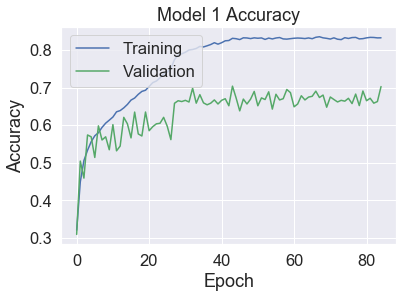

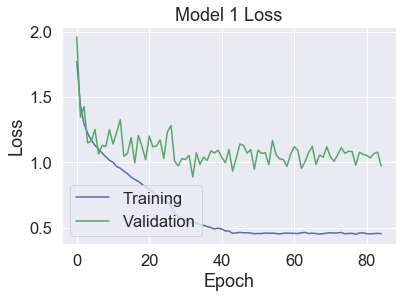

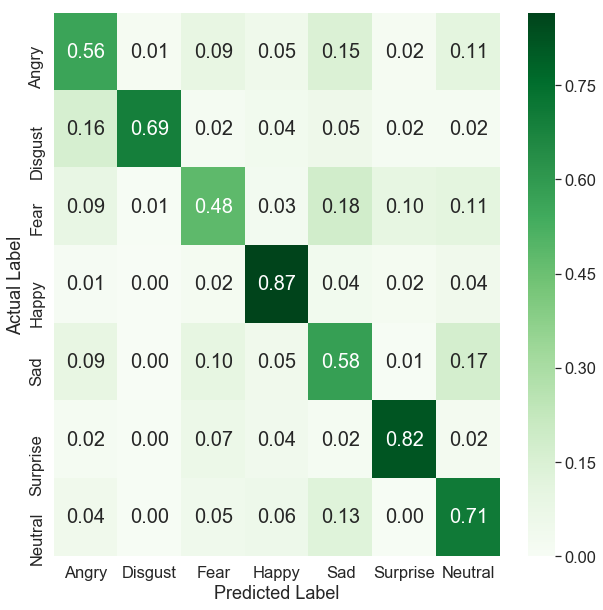

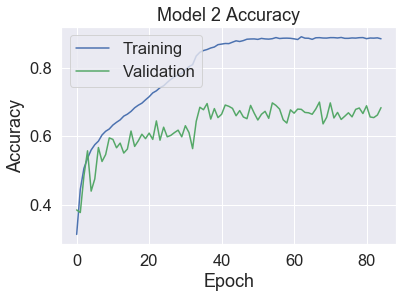

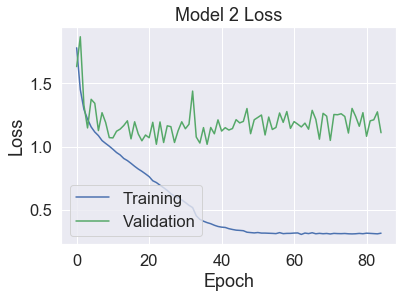

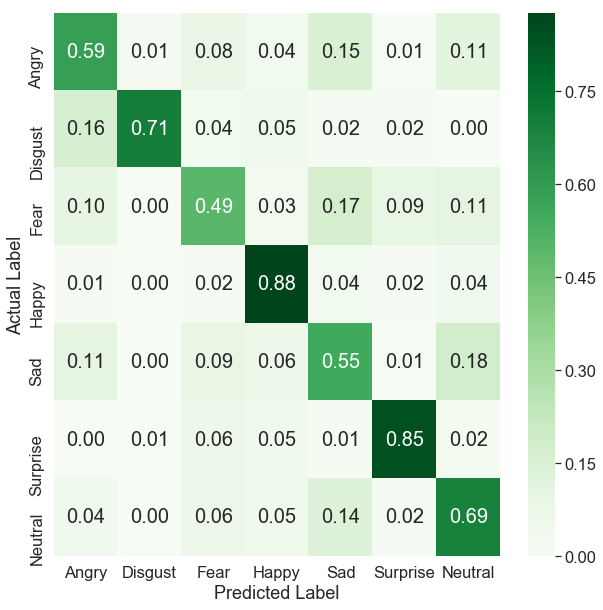

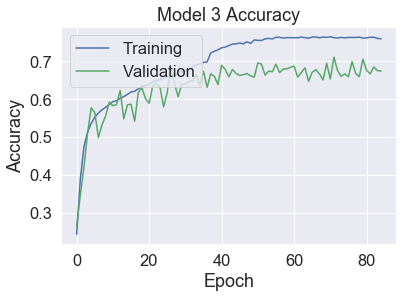

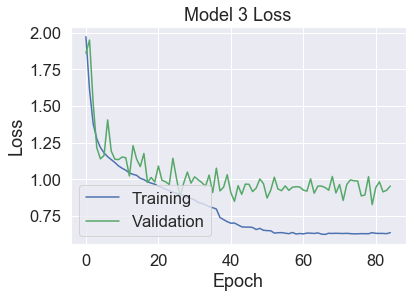

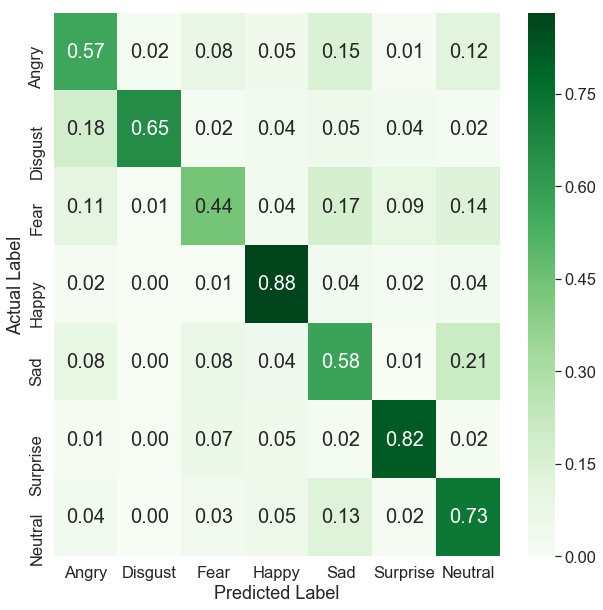

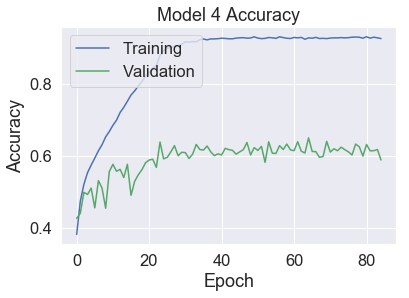

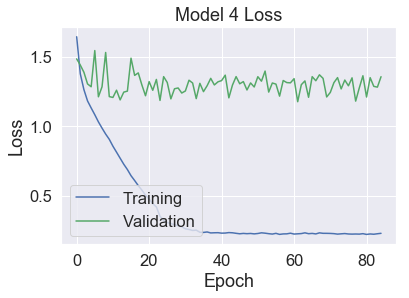

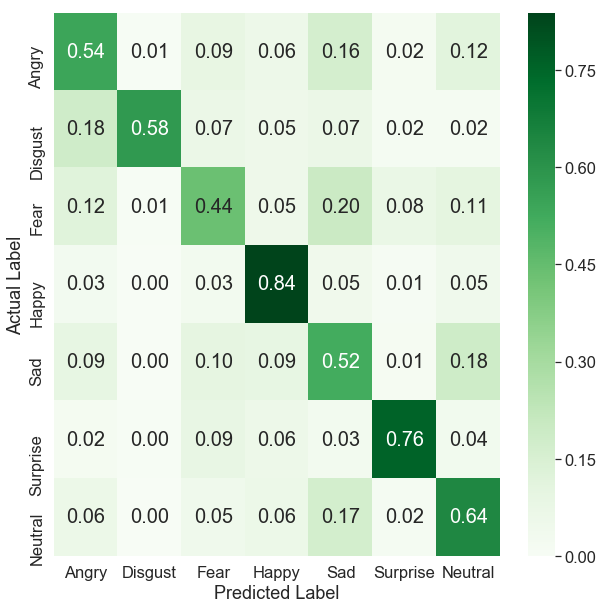

In [18]:
# Model 1 Stats
plt.figure()
plt.plot(history1.history['acc'], color='b', label='Training')
plt.plot(history1.history['val_acc'], color='g', label='Validation')
plt.title('Model 1 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.figure()
plt.plot(history1.history['loss'], color='b', label='Training')
plt.plot(history1.history['val_loss'], color='g', label='Validation')
plt.title('Model 1 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='lower left')
plt.show()

y_pred = model1.predict_classes(X_test)
y_true = np.asarray([np.argmax(i) for i in y_test])

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(
    cm_norm, annot=True, linewidths=0, square=False, cmap='Greens', 
    yticklabels=emotion_labels, xticklabels=emotion_labels, 
    vmin=0, vmax=np.max(cm_norm), fmt='.2f', 
    annot_kws={'size': 20}
)
ax.set(xlabel='Predicted Label', ylabel='Actual Label')
plt.savefig(cm_file)
plt.show()


# Model 2 Stats
plt.figure()
plt.plot(history2.history['acc'], color='b', label='Training')
plt.plot(history2.history['val_acc'], color='g', label='Validation')
plt.title('Model 2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.figure()
plt.plot(history2.history['loss'], color='b', label='Training')
plt.plot(history2.history['val_loss'], color='g', label='Validation')
plt.title('Model 2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='lower left')
plt.show()

y_pred = model2.predict_classes(X_test)
y_true = np.asarray([np.argmax(i) for i in y_test])

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(
    cm_norm, annot=True, linewidths=0, square=False, cmap='Greens', 
    yticklabels=emotion_labels, xticklabels=emotion_labels, 
    vmin=0, vmax=np.max(cm_norm), fmt='.2f', 
    annot_kws={'size': 20}
)
ax.set(xlabel='Predicted Label', ylabel='Actual Label')
plt.savefig(cm_file)
plt.show()


# Model 3 Stats
plt.figure()
plt.plot(history3.history['acc'], color='b', label='Training')
plt.plot(history3.history['val_acc'], color='g', label='Validation')
plt.title('Model 3 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.figure()
plt.plot(history3.history['loss'], color='b', label='Training')
plt.plot(history3.history['val_loss'], color='g', label='Validation')
plt.title('Model 3 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='lower left')
plt.show()

y_pred = model3.predict_classes(X_test)
y_true = np.asarray([np.argmax(i) for i in y_test])

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(
    cm_norm, annot=True, linewidths=0, square=False, cmap='Greens', 
    yticklabels=emotion_labels, xticklabels=emotion_labels, 
    vmin=0, vmax=np.max(cm_norm), fmt='.2f', 
    annot_kws={'size': 20}
)
ax.set(xlabel='Predicted Label', ylabel='Actual Label')
plt.savefig(cm_file)
plt.show()


# Model 4 Stats
plt.figure()
plt.plot(history4.history['acc'], color='b', label='Training')
plt.plot(history4.history['val_acc'], color='g', label='Validation')
plt.title('Model 4 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.figure()
plt.plot(history4.history['loss'], color='b', label='Training')
plt.plot(history4.history['val_loss'], color='g', label='Validation')
plt.title('Model 4 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='lower left')
plt.show()

y_pred = model4.predict_classes(X_test)
y_true = np.asarray([np.argmax(i) for i in y_test])

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(
    cm_norm, annot=True, linewidths=0, square=False, cmap='Greens', 
    yticklabels=emotion_labels, xticklabels=emotion_labels, 
    vmin=0, vmax=np.max(cm_norm), fmt='.2f', 
    annot_kws={'size': 20}
)
ax.set(xlabel='Predicted Label', ylabel='Actual Label')
plt.savefig(cm_file)
plt.show()

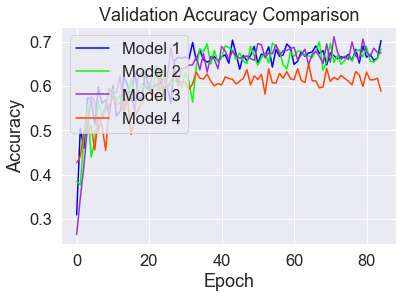

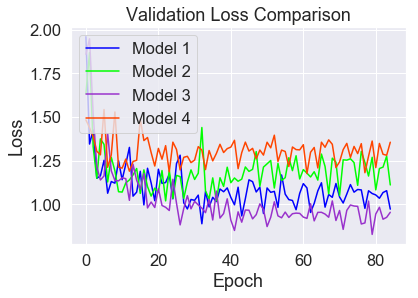

In [19]:
# Validation Comparison
fig1 = plt.figure()
plt.plot(history1.history['val_acc'], color='#0000FF', label='Model 1')
plt.plot(history2.history['val_acc'], color='#00FF00', label='Model 2')
plt.plot(history3.history['val_acc'], color='#9932CC', label='Model 3')
plt.plot(history4.history['val_acc'], color='#FF4500', label='Model 4')
plt.title('Validation Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.savefig(acc_file)
plt.show() 

# Loss Comparison
fig1 = plt.figure()
plt.plot(history1.history['val_loss'], color='#0000FF', label='Model 1')
plt.plot(history2.history['val_loss'], color='#00FF00', label='Model 2')
plt.plot(history3.history['val_loss'], color='#9932CC', label='Model 3')
plt.plot(history4.history['val_loss'], color='#FF4500', label='Model 4')
plt.title('Validation Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.savefig(acc_file)
plt.show() 